In [1]:
# Librerias necesarias
from CoffeaDelphes import Converter
import numpy as np
import matplotlib.pyplot as plt
from hist import Hist
import mplhep as hep
import pandas as pd
import glob
import coffea

plt.style.use([hep.style.ROOT])

import warnings
warnings.filterwarnings('ignore')

In [2]:
runs = ["run_0{}".format(x+1) if x < 9 else "run_{}".format(x+1) for x in range(21) ]
fname = ["/cms/mc/MG5_aMC_v3_1_1/Zbbbar_schannel/Events/{}/tag_1_delphes_events.root".format(run) for run in runs ]

In [3]:
dc =  {"jet_pt0":[],"jet_pt1":[],"jet_pt2":[],"jet_pt3":[],
       "jet_eta0":[],"jet_eta1":[],"jet_eta2":[],"jet_eta3":[],
       "jet_phi0":[],"jet_phi1":[],"jet_phi2":[],"jet_phi3":[],
       'jet_btag0':[], 'jet_btag1':[], 'jet_btag2':[], 'jet_btag3':[],
       'jet_mass0':[], 'jet_mass1':[], 'jet_mass2':[], 'jet_mass3':[],
       'missinget_met':[],'missinget_phi':[]}
df_all = pd.DataFrame(dc)
df_all.head()

,jet_pt0,jet_pt1,jet_pt2,jet_pt3,jet_eta0,jet_eta1,jet_eta2,jet_eta3,jet_phi0,jet_phi1,...,jet_btag0,jet_btag1,jet_btag2,jet_btag3,jet_mass0,jet_mass1,jet_mass2,jet_mass3,missinget_met,missinget_phi


In [4]:
for index,path in enumerate(fname):
    tree_temp = Converter(path)
    events_temp = {"Jet": ["PT", "Eta", "Phi", "Mass", "BTag"], "MissingET": ["MET", "Phi"]}
    tree_temp.generate(events_temp)
    df_temp = tree_temp.df
    print(index+1,"- Tamaño del dataframe temporal:",len(df_temp))
    df_all = pd.concat([df_all,df_temp], ignore_index=True)
print("Tamaño del dataframe total es:",len(df_all))

1 - Tamaño del dataframe temporal: 40479
2 - Tamaño del dataframe temporal: 40404
3 - Tamaño del dataframe temporal: 40445
4 - Tamaño del dataframe temporal: 40270
5 - Tamaño del dataframe temporal: 40428
6 - Tamaño del dataframe temporal: 40606
7 - Tamaño del dataframe temporal: 40306
8 - Tamaño del dataframe temporal: 40497
9 - Tamaño del dataframe temporal: 40395
10 - Tamaño del dataframe temporal: 40380
11 - Tamaño del dataframe temporal: 40387
12 - Tamaño del dataframe temporal: 40189
13 - Tamaño del dataframe temporal: 40412
14 - Tamaño del dataframe temporal: 40409
15 - Tamaño del dataframe temporal: 40536
16 - Tamaño del dataframe temporal: 40418
17 - Tamaño del dataframe temporal: 40415
18 - Tamaño del dataframe temporal: 40282
19 - Tamaño del dataframe temporal: 40463
20 - Tamaño del dataframe temporal: 40469
21 - Tamaño del dataframe temporal: 40378
Tamaño del dataframe total es: 848568


In [11]:
df_all.head()

,jet_pt0,jet_pt1,jet_pt2,jet_pt3,jet_eta0,jet_eta1,jet_eta2,jet_eta3,jet_phi0,jet_phi1,...,jet_btag0,jet_btag1,jet_btag2,jet_btag3,jet_mass0,jet_mass1,jet_mass2,jet_mass3,missinget_met,missinget_phi
0,49.766636,22.000076,15.540462,12.993957,0.732920,3.576957,0.460618,-0.332936,-2.955821,-0.429333,...,0.0,0.0,0.0,0.0,10.035754,2.523244,2.507966e+00,2.878206,22.043629,0.317358
1,43.527985,33.257496,11.519303,8.779058,1.802477,2.784046,0.613198,0.826044,2.700448,-0.334208,...,0.0,0.0,0.0,0.0,5.690470,4.190277,-1.685874e-07,1.172311,24.521704,-0.070003
2,31.341011,25.956022,12.884939,11.498661,2.758761,4.300023,1.164700,-1.292872,-0.650612,2.326473,...,0.0,0.0,0.0,0.0,4.790336,4.203971,2.118908e+00,2.110380,8.981977,-1.078047
3,37.145149,29.016415,16.852125,9.148043,-2.616840,-3.913533,-1.028525,-4.105178,1.714193,-0.665438,...,0.0,0.0,0.0,0.0,4.786722,3.441108,2.382083e+00,1.309144,1.926296,1.420844
4,13.395885,4.819166,4.721497,4.709152,3.915345,1.451118,3.384626,3.906830,-2.832071,-1.524035,...,0.0,0.0,0.0,0.0,2.906953,0.933597,5.295412e-01,0.000002,8.514373,1.139108


In [13]:
# formulas para Delta phi, Abs Delta phi y DeltaR
def DeltaPhi(i,row, col1, col2):
    """
    correction on azimuthal angle difference dphi
    """
    dphi = (row[col1] - row[col2])[i]
    if dphi >= np.pi:
        dphi -= 2*np.pi
    if dphi < -np.pi:
        dphi += 2*np.pi
    return dphi

def AbsDeltaPhi(i,rowa, col1a, col2a = 'met_Phi'):
    return np.abs(DeltaPhi(i,rowa, col1a, col2a))

def DeltaR(Deta,Dphi):
    return np.sqrt( Deta**2 + Dphi**2 )

def pt_jet(data,feature,min_range,max_range, bin):
    '''
    Realiza un grafico de cada objeto.
    '''
    
    #fig = plt.figure(figsize=(6,4))
    box_style=dict(boxstyle='square', alpha=0.5)
    text = "n_events: {}".format(data[feature].count())+"\n" \
            +"mean: {}".format(np.round(data[feature].mean(),2))+"\n" \
            +"std: {}".format(np.round(data[feature].std(),2))
    plt.hist(data[feature],bins=bin)
    
    ax = plt.gca()
    p = ax.patches  
    heights = [patch.get_height() for patch in p]
    if feature[:6] == "Delta_": num = 3
    else: num = 1.8
    
    plt.title("Histograma del objeto: {}".format(feature),size=15)
    #plt.xlabel("pT [GeV]",size=10)
    plt.ylabel("Eventos",size=10)
    plt.text(max_range/num,max(heights)/1.3, text,bbox=box_style,size=12)
    plt.xlim(min_range,max_range)

## Hitogramas de pT

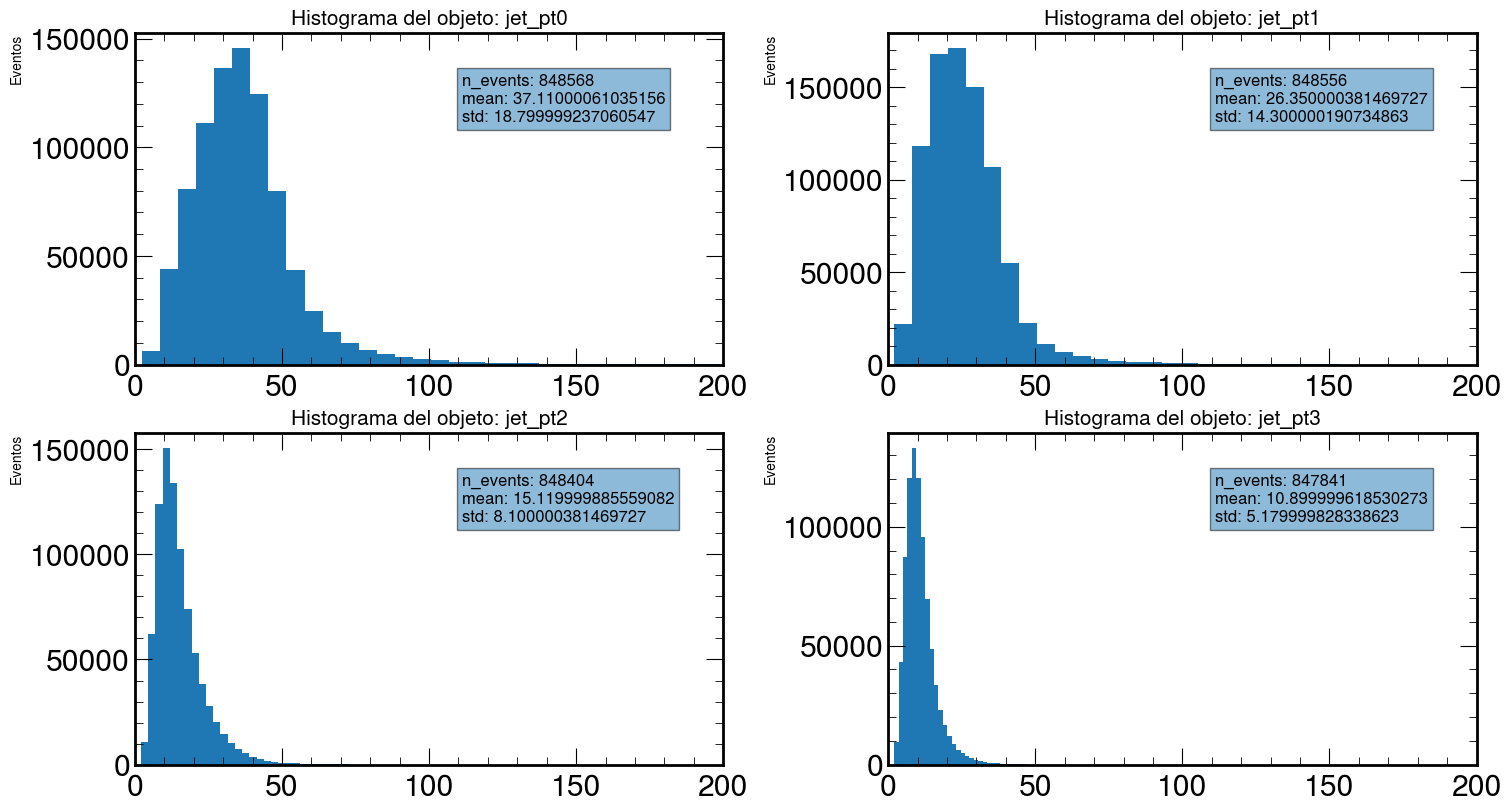

In [14]:
plt.figure(figsize=(15,8),constrained_layout=True)

plt.subplot(2,2,1)
pt_jet(df_all,"jet_pt0",0,200,100)
plt.subplot(2,2,2)
pt_jet(df_all,"jet_pt1",0,200,100)
plt.subplot(2,2,3)
pt_jet(df_all,"jet_pt2",0,200,100)
plt.subplot(2,2,4)
pt_jet(df_all,"jet_pt3",0,200,100)

## Hitogramas de $\eta$

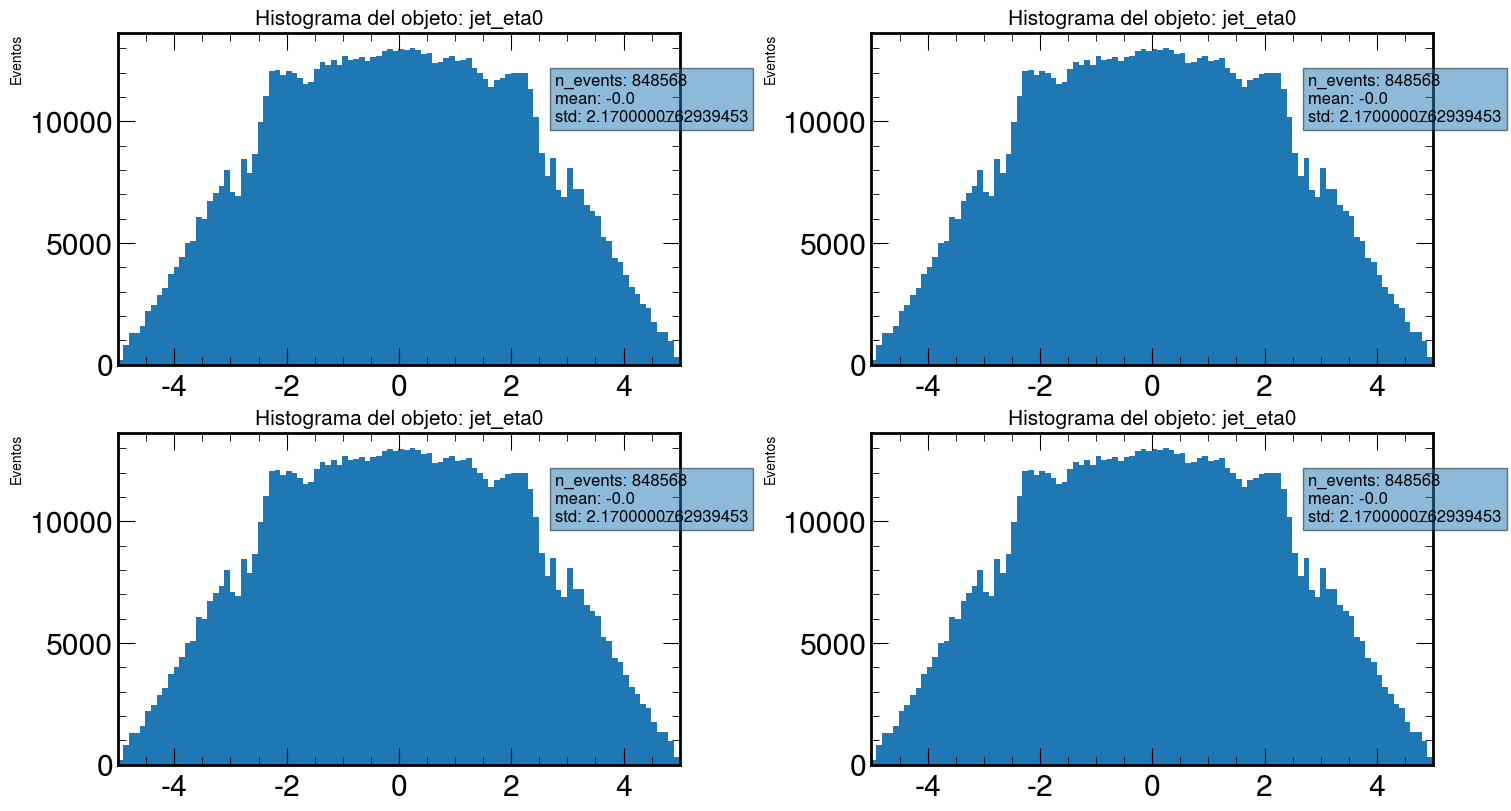

In [15]:
plt.figure(figsize=(15,8),constrained_layout=True)

plt.subplot(2,2,1)
pt_jet(df_all,'jet_eta0',-5,5,100)
plt.subplot(2,2,2)
pt_jet(df_all,'jet_eta0',-5,5,100)
plt.subplot(2,2,3)
pt_jet(df_all,'jet_eta0',-5,5,100)
plt.subplot(2,2,4)
pt_jet(df_all,'jet_eta0',-5,5,100)

## Hitogramas de $\phi$

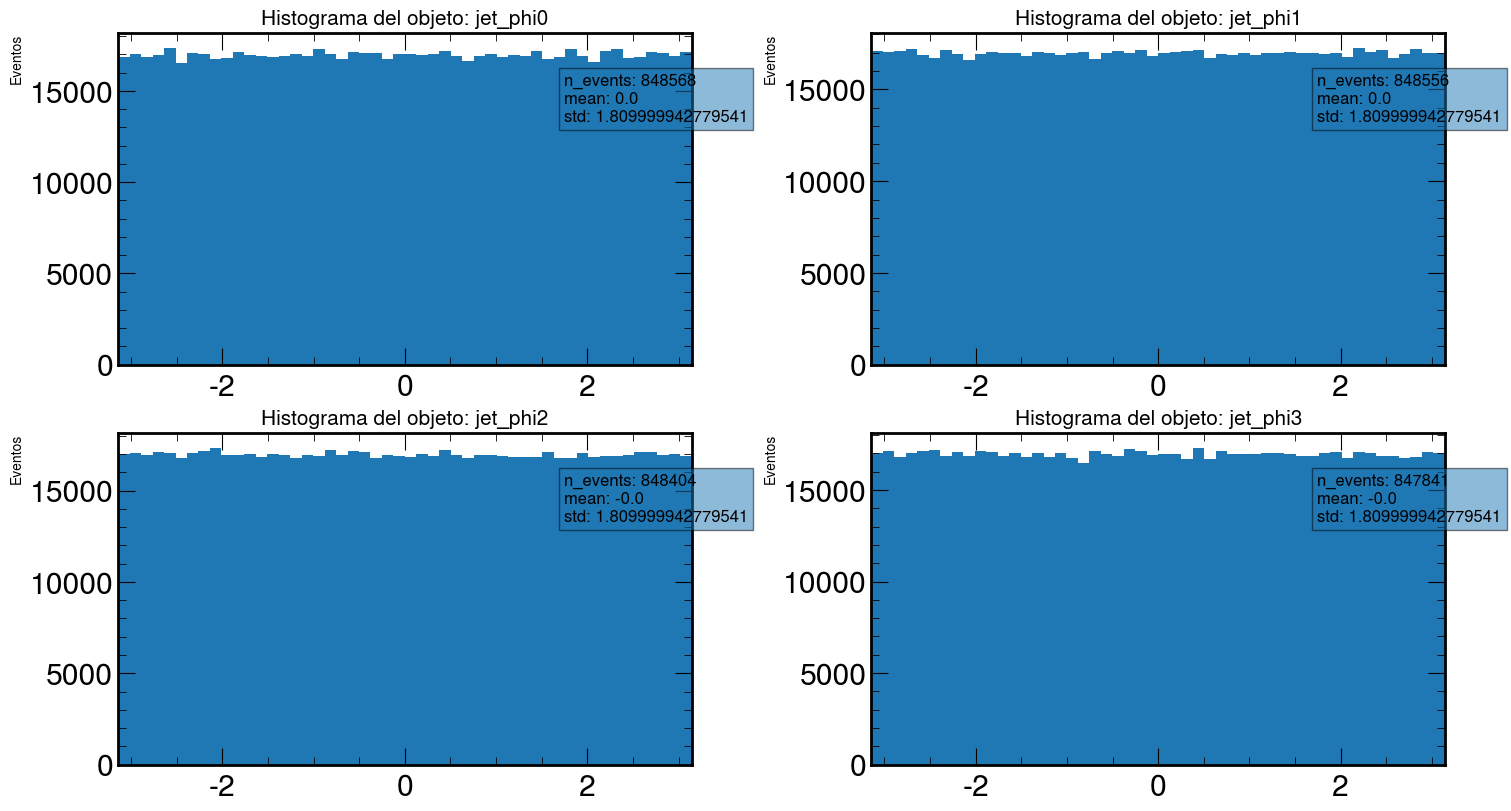

In [16]:
plt.figure(figsize=(15,8),constrained_layout=True)

plt.subplot(2,2,1)
pt_jet(df_all,'jet_phi0',-np.pi,np.pi,50)
plt.subplot(2,2,2)
pt_jet(df_all,'jet_phi1',-np.pi,np.pi,50)
plt.subplot(2,2,3)
pt_jet(df_all,'jet_phi2',-np.pi,np.pi,50)
plt.subplot(2,2,4)
pt_jet(df_all,'jet_phi3',-np.pi,np.pi,50)

## Analisis para los b-jets (b1,b2) en la run_01
Eventos con 2 jets taggeados como b

In [18]:
f = df_all[["jet_btag0","jet_btag1","jet_btag2","jet_btag3"]]
f_list = [ sum(f.loc[i]) for i in range(len(f)) ]
df_all.insert(1,"n_jets",f_list)

data_filtered = df_all[df_all["n_jets"] == 2]
print("Numero de eventos con 2 jets:",len(data_filtered))
data2 = data_filtered[["jet_btag0","jet_btag1","jet_btag2","jet_btag3","n_jets","jet_pt0","jet_pt1","jet_pt2","jet_pt3",'jet_mass0', 'jet_mass1', 'jet_mass2', 'jet_mass3']]
data2.head()

Numero de eventos con 2 jets: 157166


,jet_btag0,jet_btag1,jet_btag2,jet_btag3,n_jets,jet_pt0,jet_pt1,jet_pt2,jet_pt3,jet_mass0,jet_mass1,jet_mass2,jet_mass3
6,1.0,0.0,0.0,1.0,2.0,19.393379,10.207476,6.240767,5.777122,3.096600,2.251030,0.376815,1.024425
8,1.0,1.0,0.0,0.0,2.0,32.055767,31.602999,6.987425,6.673363,6.419279,4.302526,1.237752,1.586928
21,1.0,1.0,0.0,0.0,2.0,30.307781,26.745689,22.093033,6.491794,4.424043,2.922203,4.843198,0.979918
31,1.0,1.0,0.0,0.0,2.0,40.389709,16.412298,10.564023,8.602764,7.247279,2.266398,1.884463,1.869094
47,1.0,1.0,0.0,0.0,2.0,45.631542,34.100296,11.894100,10.977970,7.529320,5.970905,2.715895,1.529626


In [19]:
tag_pt = []
tag_eta = []
tag_phi = []
tag_mass = []
for i in range(data2.shape[0]):
    pt = []
    eta = []
    phi = []
    mass = []
    if data2.iloc[i][0] == 1.0: 
        pt.append(data_filtered.jet_pt0.to_list()[i])
        eta.append(data_filtered.jet_eta0.to_list()[i])
        phi.append(data_filtered.jet_phi0.to_list()[i])
        mass.append(data_filtered.jet_mass0.to_list()[i])
    if data2.iloc[i][1] == 1.0: 
        pt.append(data_filtered.jet_pt1.to_list()[i])
        eta.append(data_filtered.jet_eta1.to_list()[i])
        phi.append(data_filtered.jet_phi1.to_list()[i])
        mass.append(data_filtered.jet_mass1.to_list()[i])
    if data2.iloc[i][2] == 1.0: 
        pt.append(data_filtered.jet_pt2.to_list()[i])
        eta.append(data_filtered.jet_eta2.to_list()[i])
        phi.append(data_filtered.jet_phi2.to_list()[i])
        mass.append(data_filtered.jet_mass2.to_list()[i])
    if data2.iloc[i][3] == 1.0: 
        pt.append(data_filtered.jet_pt3.to_list()[i])
        eta.append(data_filtered.jet_eta3.to_list()[i])
        phi.append(data_filtered.jet_phi3.to_list()[i])
        mass.append(data_filtered.jet_mass3.to_list()[i])
    tag_pt.append(pt)
    tag_eta.append(eta)
    tag_phi.append(phi)
    tag_mass.append(mass)


jet_pt_b1 = [j[0] for j in tag_pt]
jet_pt_b2 = [j[1] for j in tag_pt]
jet_eta_b1 = [j[0] for j in tag_eta]
jet_eta_b2 = [j[1] for j in tag_eta]
jet_phi_b1 = [j[0] for j in tag_phi]
jet_phi_b2 = [j[1] for j in tag_phi]
jet_mass_b1 = [j[0] for j in tag_mass]
jet_mass_b2 = [j[1] for j in tag_mass]


di = {"jet_pt_b1":jet_pt_b1,"jet_pt_b2":jet_pt_b2,
      "jet_eta_b1":jet_eta_b1,"jet_eta_b2":jet_eta_b2,
      "jet_phi_b1":jet_phi_b1,"jet_phi_b2":jet_phi_b2,
      "jet_mass_b1":jet_mass_b1,"jet_mass_b2":jet_mass_b2}

data_bjet = pd.DataFrame(di)
data_bjet.head()

,jet_pt_b1,jet_pt_b2,jet_eta_b1,jet_eta_b2,jet_phi_b1,jet_phi_b2,jet_mass_b1,jet_mass_b2
0,19.393379,5.777122,1.014040,-1.776975,1.385800,-0.925352,3.096600,1.024425
1,32.055767,31.602999,-1.842887,-2.135534,2.976409,-0.026138,6.419279,4.302526
2,30.307781,26.745689,0.362868,-1.276194,-1.337182,1.421419,4.424043,2.922203
3,40.389709,16.412298,0.111644,-1.463557,0.193683,-2.966999,7.247279,2.266398
4,45.631542,34.100296,-0.998331,-0.053873,-1.166278,1.899346,7.529320,5.970905


In [20]:
phi_cor = []
for i in range(len(data_bjet)):
    phi_cor.append(AbsDeltaPhi(i,data_bjet,"jet_phi_b1","jet_phi_b2"))

data_bjet['Delta_eta_b'] = data_bjet.jet_eta_b2 - data_bjet.jet_eta_b1
data_bjet['Delta_phi_b'] = phi_cor
data_bjet["DeltaR_b"] = DeltaR(data_bjet.Delta_eta_b,data_bjet.Delta_phi_b)

In [21]:
data_bjet.head()

,jet_pt_b1,jet_pt_b2,jet_eta_b1,jet_eta_b2,jet_phi_b1,jet_phi_b2,jet_mass_b1,jet_mass_b2,Delta_eta_b,Delta_phi_b,DeltaR_b
0,19.393379,5.777122,1.014040,-1.776975,1.385800,-0.925352,3.096600,1.024425,-2.791015,2.311151,3.623698
1,32.055767,31.602999,-1.842887,-2.135534,2.976409,-0.026138,6.419279,4.302526,-0.292647,3.002547,3.016774
2,30.307781,26.745689,0.362868,-1.276194,-1.337182,1.421419,4.424043,2.922203,-1.639062,2.758601,3.208800
3,40.389709,16.412298,0.111644,-1.463557,0.193683,-2.966999,7.247279,2.266398,-1.575201,3.122503,3.497325
4,45.631542,34.100296,-0.998331,-0.053873,-1.166278,1.899346,7.529320,5.970905,0.944458,3.065624,3.207811


## Histogramas para los pT(b1,b2)

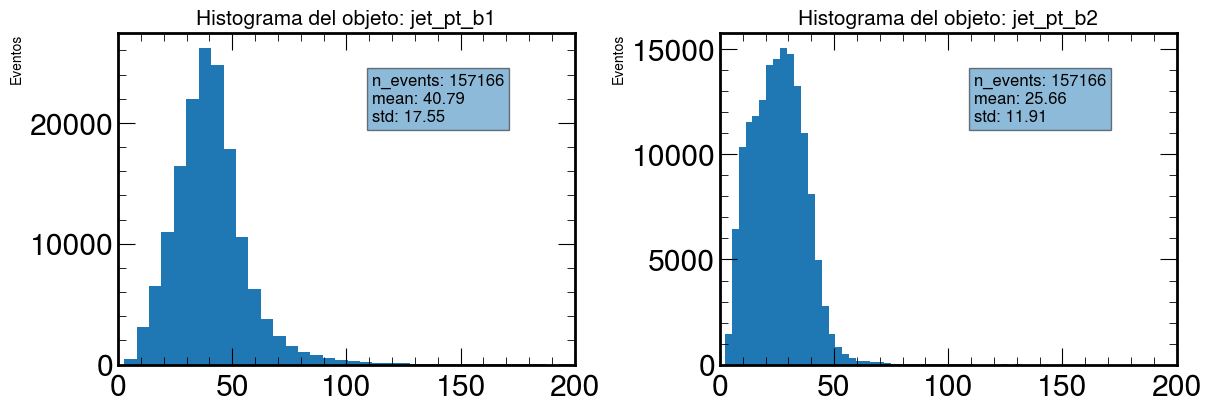

In [22]:
plt.figure(figsize=(12,4),constrained_layout=True)

plt.subplot(1,2,1)
pt_jet(data_bjet,"jet_pt_b1",0,200,100)
plt.subplot(1,2,2)
pt_jet(data_bjet,"jet_pt_b2",0,200,100)

## Histogramas para los $\eta$(b1,b2)

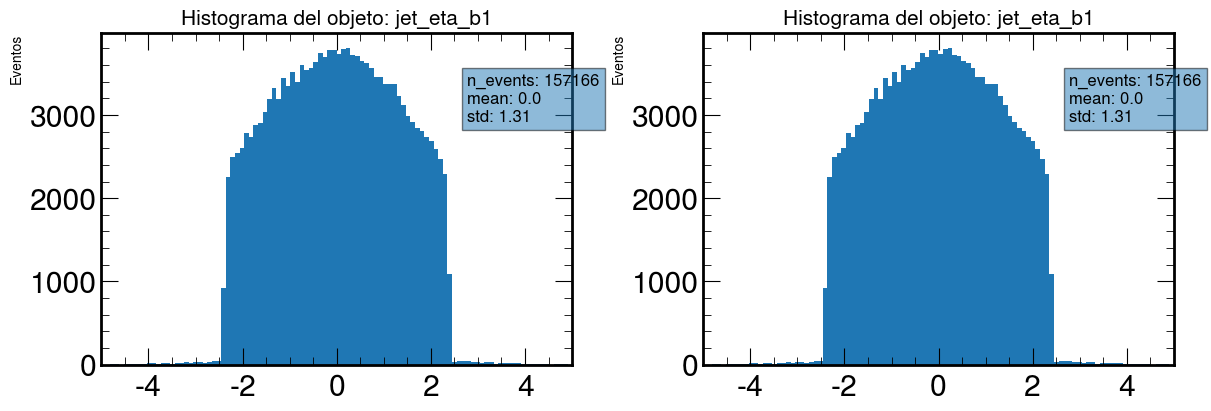

In [23]:
plt.figure(figsize=(12,4),constrained_layout=True)

plt.subplot(1,2,1)
pt_jet(data_bjet,'jet_eta_b1',-5,5,100)
plt.subplot(1,2,2)
pt_jet(data_bjet,'jet_eta_b1',-5,5,100)

## Histogramas para los $\phi$(b1,b2)

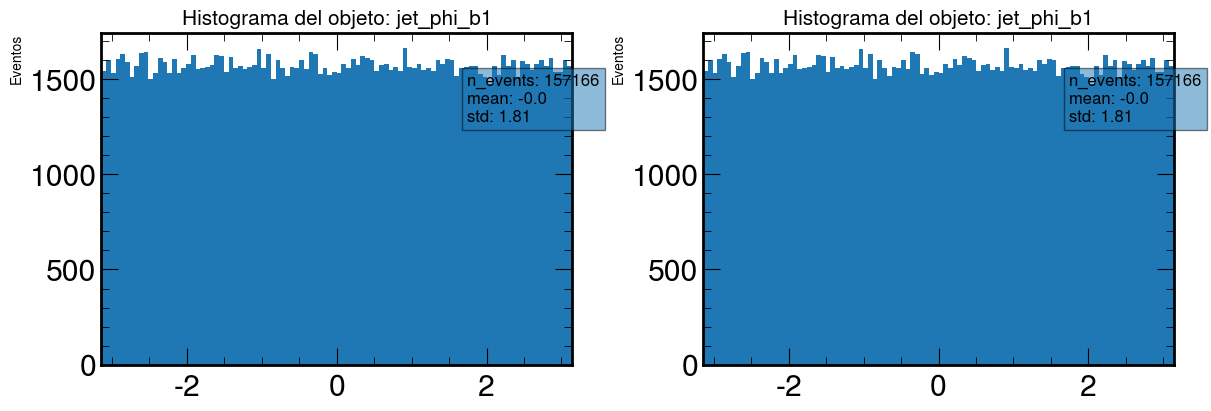

In [24]:
plt.figure(figsize=(12,4),constrained_layout=True)

plt.subplot(1,2,1)
pt_jet(data_bjet,'jet_phi_b1',-np.pi,np.pi,100)
plt.subplot(1,2,2)
pt_jet(data_bjet,'jet_phi_b1',-np.pi,np.pi,100)

## Histogramas para el $\Delta R$

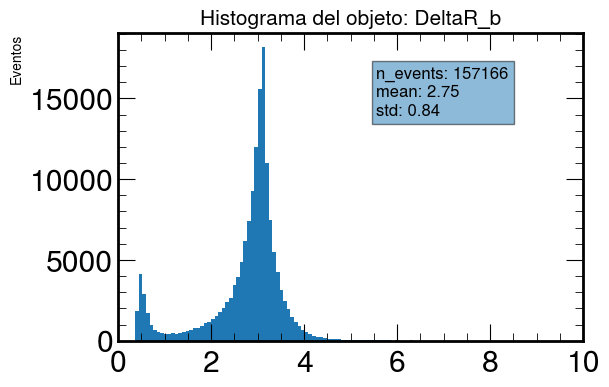

In [25]:
plt.figure(figsize=(6,4))
pt_jet(data_bjet,"DeltaR_b",0,10,100)

## Histogramas para los $\Delta \phi$, $\Delta \eta$
Notamos que el $\Delta \phi$ esta definido de 0 hasta $\pi$ y se grafica positivo debido a como esta definido el valor absoluto de esta cantidad

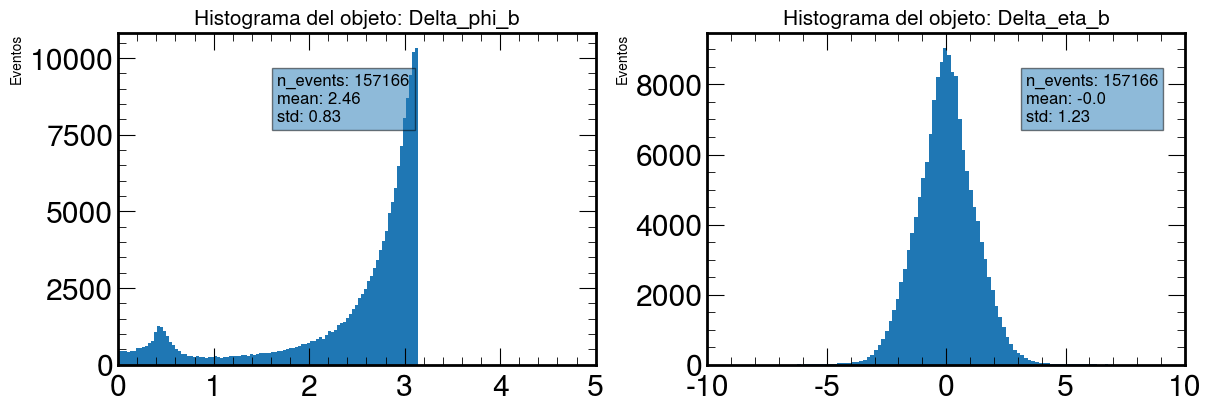

In [26]:
plt.figure(figsize=(12,4),constrained_layout=True)

plt.subplot(1,2,1)
pt_jet(data_bjet,'Delta_phi_b',0,5,100)
plt.subplot(1,2,2)
pt_jet(data_bjet,'Delta_eta_b',-10,10,100)

## Rapidez "$y$" en terminos de $\eta$
$\begin{equation}
y = ln \left ( \frac{\sqrt{m^{2} + p_{T}^{2}cosh^{2}(\eta)}+ p_{T}sinh(\eta)}{\sqrt{m^{2} + p_{T}^{2}}} \right )
\end{equation}$

referencia: [rapidez de particulas](https://hmong.es/wiki/Pseudorapidity)]

In [27]:
def y(m,eta,pt):
    return np.log( (np.sqrt(m**2 + (pt**2)*(np.cosh(eta)**2)) + pt*np.sinh(eta)) / (np.sqrt(m**2 + pt**2)) )

y1 = y(data_bjet.jet_mass_b1,data_bjet.jet_eta_b1,data_bjet.jet_pt_b1)
y2 = y(data_bjet.jet_mass_b2,data_bjet.jet_eta_b2,data_bjet.jet_pt_b2)

data_bjet['y1'] = y1
data_bjet['y2'] = y2

In [33]:
data_bjet.to_csv("data_bjet_all.csv",index=False)

## Histogramas de Rapidez $y(b1)=y1$,$y(b2)=y2$

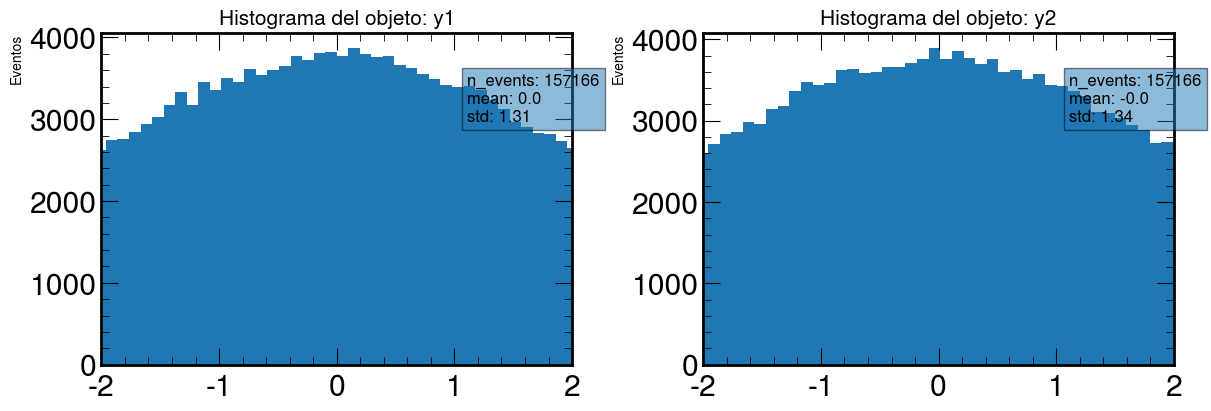

In [28]:
plt.figure(figsize=(12,4),constrained_layout=True)

plt.subplot(1,2,1)
pt_jet(data_bjet,'y1',-2,2,100)
plt.subplot(1,2,2)
pt_jet(data_bjet,'y2',-2,2,100)

## Masa invariante en Colisionadores de particulas:

$\begin{equation}
M^{2} = 2P_{T1}P_{T2}[ cosh(y_{1} - y_{2}) - cos(\phi _{1} - \phi _{2}) ]
\end{equation}$

In [29]:
def inv_mass(pt1,pt2,y1,y2,Dphi):
    return np.sqrt(2*pt1*pt2*(np.cosh(y1 - y2) - np.cos(Dphi)))

inv_m = inv_mass(data_bjet.jet_pt_b1,data_bjet.jet_pt_b2,
                 data_bjet.y1,data_bjet.y2,
                 data_bjet.Delta_phi_b)

data_bjet["inv_mass_b"] = inv_m # agregamos al dataset la masa invariante.

def inv_mass(pt1,pt2,Deta,Dphi):
    return np.sqrt(2*pt1*pt2*(np.cosh(Deta) - np.cos(Dphi)))

inv_m = inv_mass(data_bjet.jet_pt_b1,data_bjet.jet_pt_b2,
                 data_bjet.Delta_eta_b,
                 data_bjet.Delta_phi_b)

data_bjet["inv_mass_b_eta"] = inv_m # agregamos al dataset la masa invariante.

## Histograma para Masa invariante usando definicion de $y$ (izquierda) y usando la definicion de $\eta$ (derecha)

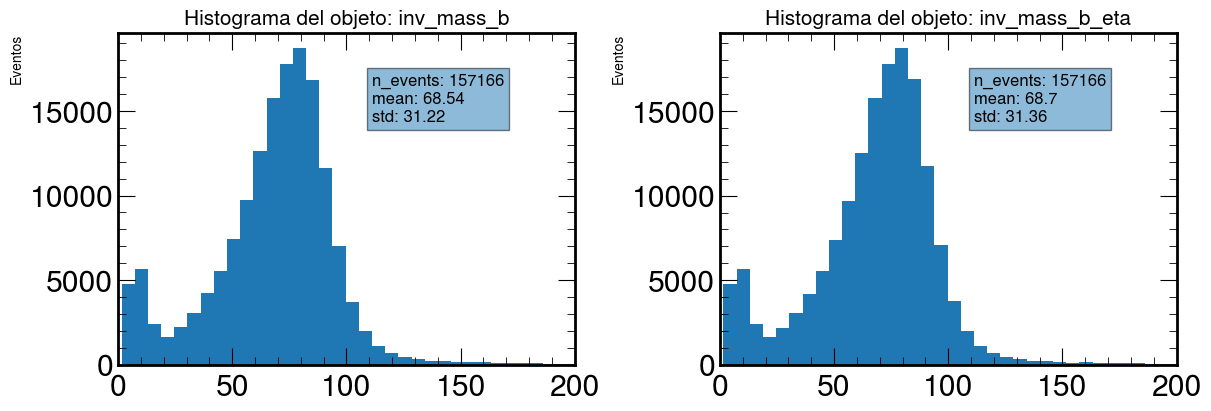

In [37]:
plt.figure(figsize=(12,4),constrained_layout=True)

plt.subplot(1,2,1)
pt_jet(data_bjet,"inv_mass_b",0,200,200)
plt.subplot(1,2,2)
pt_jet(data_bjet,"inv_mass_b_eta",0,200,200)

## MET

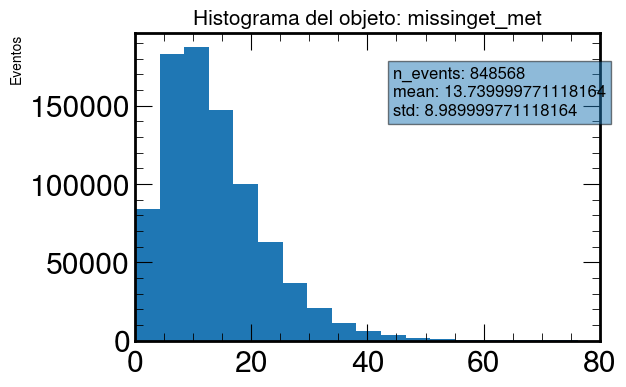

In [38]:
plt.figure(figsize=(6,4))
pt_jet(df_all,'missinget_met',0,80,200)